In [70]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.ensemble import MajorityVotingClassifier
from skmultilearn.cluster import FixedLabelSpaceClusterer
from skmultilearn.ensemble import RakelO
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from mlxtend.evaluate.time_series import GroupTimeSeriesSplit
from mlxtend.evaluate.time_series import plot_splits
from mlxtend.evaluate.time_series import print_cv_info
from mlxtend.evaluate.time_series import print_split_info
import optuna
from functools import partial
from collected_functions import *

Load combined MA and DDS training data

In [2]:
df = pd.read_parquet('combined_training_set.parquet')
# df = df.sort_values(by='year', ascending=True)
print(df.shape)
df.head()

(6566, 21)


,incidentId,state,incidentTypeMA,region,maType,maPriority,supportFunction,agencyId,maId,declarationType,...,statementOfWork,femaDeclarationString,incidentType,incidentBeginDate,fipsStateCode,designatedIncidentTypes,declarationTitle,year,month,day
45,2018072401,CA,Fire,9,FOS,High,13.0,DHS-FPS,4382DRCAFPS01,DR,...,"As directed by an in coordination with FEMA, F...",DR-4382-CA,Fire,2018-07-23 00:00:00+00:00,6.0,Fire,WILDFIRES AND HIGH WINDS,2018.0,7.0,23.0
66,2018072401,CA,Fire,9,FOS,High,10.0,EPA,4382DRCAEPA01,DR,...,"As directed by and in coordination with FEMA, ...",DR-4382-CA,Fire,2018-07-23 00:00:00+00:00,6.0,Fire,WILDFIRES AND HIGH WINDS,2018.0,7.0,23.0
136,2018072401,CA,Fire,9,FOS,Lifesaving,1.0,DOT,4382DRCADOT01,DR,...,"As directed by and in coordination with FEMA, ...",DR-4382-CA,Fire,2018-07-23 00:00:00+00:00,6.0,Fire,WILDFIRES AND HIGH WINDS,2018.0,7.0,23.0
152,2023121901,ME,Severe Storm,1,FOS,Normal,7.0,GSA,4754DRMEGSA03,DR,...,"As directed by and in coordination with FEMA, ...",DR-4754-ME,Severe Storm,2023-12-17 00:00:00+00:00,23.0,"Severe Storm,Flood",SEVERE STORM AND FLOODING,2023.0,12.0,17.0
153,2023121901,ME,Severe Storm,1,FOS,High,7.0,GSA,4754DRMEGSA02,DR,...,"As directed by and in coordination with FEMA, ...",DR-4754-ME,Severe Storm,2023-12-17 00:00:00+00:00,23.0,"Severe Storm,Flood",SEVERE STORM AND FLOODING,2023.0,12.0,17.0


Compared to the original multilabel_classification_condensed notebook which grouped by state/incidentType/region, the approach in this notebook will group by incidentId, state, incidentType, and region. 

In [3]:
feature_columns = [
    'incidentId',
    'state',
    'designatedIncidentTypes',
    'declarationType',
    'region',
    'year'
]
kept_feature_columns = [
    'incidentId',
    'state',
    'declarationType',
    'region',
]
target_column = 'supportFunction'

X_train, y_train = create_set(df, feature_columns, target_column)

print(X_train.shape, len(y_train))
print(y_train[:5])
X_train.head(5)

(485, 6) 485
0    [1.0, 3.0, 4.0, 7.0, 8.0, 10.0, 11.0, 12.0, 15.0]
1                                                [4.0]
2                                                [7.0]
3                                                [2.0]
4                                                [7.0]
Name: supportFunction, dtype: object


,incidentId,state,designatedIncidentTypes,declarationType,region,year
0,2012102505,CT,Hurricane,DR,1,2012.0
1,2012102505,DC,Hurricane,EM,3,2012.0
2,2012102505,DE,Hurricane,DR,3,2012.0
3,2012102505,DE,Hurricane,EM,3,2012.0
4,2012102505,MD,Hurricane,DR,3,2012.0


In [4]:
X_train['designatedIncidentTypes'] = X_train['designatedIncidentTypes'].str.split(',')


In [5]:
feature_columns_transform = [
    # 'incidentId',
    'state',
    # 'designatedIncidentTypes',
    'declarationType',
    'region',
]
X_train_transformed, y_train_transformed, preprocessor_X, preprocessor_y = transform_x_y_train(
    X_train,
    y_train,
    feature_columns_transform,
    ['designatedIncidentTypes'],
    target_column
)

In [6]:
groups_by_year = X_train_transformed['year'].values
X_train_transformed.drop(columns=['incidentId', 'year'], inplace=True)
print(X_train_transformed.shape)
X_train_transformed.head()

(485, 88)


,state_AK,state_AL,state_AR,state_AS,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,...,designatedIncidentTypes_Severe Ice Storm,designatedIncidentTypes_Severe Storm,designatedIncidentTypes_Snowstorm,designatedIncidentTypes_Straight-Line Winds,designatedIncidentTypes_Terrorist,designatedIncidentTypes_Tornado,designatedIncidentTypes_Tropical Storm,designatedIncidentTypes_Typhoon,designatedIncidentTypes_Volcanic Eruption,designatedIncidentTypes_Winter Storm
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
print(y_train_transformed.shape)
y_train_transformed.head()

(485, 16)


,ESF_0,ESF_1,ESF_2,ESF_3,ESF_4,ESF_5,ESF_6,ESF_7,ESF_8,ESF_9,ESF_10,ESF_11,ESF_12,ESF_13,ESF_14,ESF_15
0,0,1,0,1,1,0,0,1,1,0,1,1,1,0,0,1
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


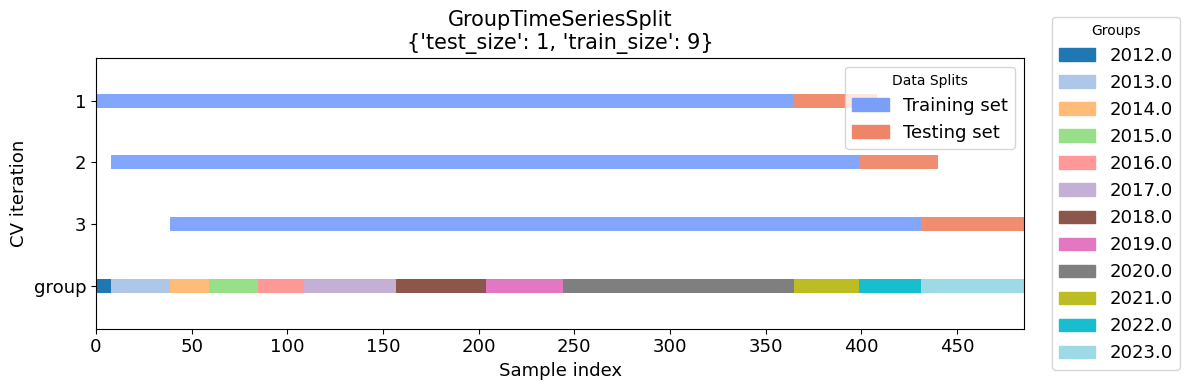

Train indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242

In [8]:
cv_args = {"test_size": 1, "train_size": 9}
plot_splits(X_train_transformed, y_train_transformed, groups_by_year, **cv_args)
print_split_info(X_train_transformed, y_train_transformed, groups_by_year, **cv_args)

In [9]:
cv = GroupTimeSeriesSplit(**cv_args)

In [28]:
clf = BinaryRelevance(
    classifier = XGBClassifier(
        max_depth=10,
        random_state=0,
        n_estimators=100,
        base_score=0.5
        ),
    require_dense = [True, True]
)

scores = cross_val_score(clf,
                         X_train_transformed,
                         y_train_transformed,
                         groups=groups_by_year,
                         scoring="f1_macro",
                         cv=cv)

print(scores)

print_cv_info(cv,
              X_train_transformed,
              y_train_transformed,
              groups_by_year,
              clf,
              scores)

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[0.42502838 0.37267099 0.36230831]
Split number: 1
Train true target: [[0 1 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [1 1 1 ... 1 0 0]]
Train predicted target: <Compressed Sparse Column sparse matrix of dtype 'int64'
	with 1395 stored elements and shape (370, 16)>
  Coords	Values
  (78, 0)	1
  (80, 0)	1
  (102, 0)	1
  (103, 0)	1
  (106, 0)	1
  (107, 0)	1
  (121, 0)	1
  (133, 0)	1
  (134, 0)	1
  (147, 0)	1
  (148, 0)	1
  (149, 0)	1
  (150, 0)	1
  (160, 0)	1
  (162, 0)	1
  (164, 0)	1
  (175, 0)	1
  (176, 0)	1
  (182, 0)	1
  (185, 0)	1
  (187, 0)	1
  (188, 0)	1
  (189, 0)	1
  (190, 0)	1
  (192, 0)	1
  :	:
  (316, 13)	1
  (319, 13)	1
  (320, 13)	1
  (326, 13)	1
  (327, 13)	1
  (332, 13)	1
  (333, 13)	1
  (334, 13)	1
  (335, 13)	1
  (345, 13)	1
  (346, 13)	1
  (348, 13)	1
  (350, 13)	1
  (361, 13)	1
  (362, 13)	1
  (363, 13)	1
  (364, 13)	1
  (366, 13)	1
  (369, 13)	1
  (10, 15)	1
  (11, 15)	1
  (136, 15)	1
  (138, 15)	1
  (140, 15)	1
  

Testing Binary Relevance model for ability to predict support functions from provided features.

In [23]:
base_SVC = SVC(
        gamma='auto',
        decision_function_shape='ovo',
        class_weight='balanced',
        )

base_XGB = XGBClassifier(
        max_depth=10,
        random_state=0,
        n_estimators=100,
        base_score=0.5
        )

base_GNB = GaussianNB()

In [24]:
br_classifier_svc = BinaryRelevance(
    classifier = base_SVC,
    require_dense = [True, True]
)
br_classifier_svc.fit(X_train_transformed, y_train_transformed)

predictions_brsvc = br_classifier_svc.predict(X_train_transformed)
predictions_brsvc_dense = predictions_brsvc.toarray()
display_results(y_train_transformed, predictions_brsvc_dense)

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/User

True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      1      0      1      1      0      0      1      1      0   
1      0      0      0      0      1      0      0      0      0      0   
2      0      0      0      0      0      0      0      1      0      0   
3      0      0      1      0      0      0      0      0      0      0   
4      0      0      0      0      0      0      0      1      0      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       1       1       1       0       0       1  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       0       0       0  
4       0       0       0       0       0       0  

Predicted Multi-Label Targets:
[[0 1 1 1 1 1 1 1 0 1 0 0 1 1 0 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1]
 [0 0 1 0 1 1 1 1 1 1 0 1 1 1 0 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1]
 [0 0 1 0 1 1 1 1 1 1 0 1 1 1 0 1]]

Su

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [25]:
br_classifier_XGB = BinaryRelevance(
    classifier = base_XGB,
    require_dense = [True, True]
)
br_classifier_XGB.fit(X_train_transformed, y_train_transformed)

predictions_brxgb = br_classifier_XGB.predict(X_train_transformed)
predictions_brxgb_dense = predictions_brxgb.toarray()
display_results(y_train_transformed, predictions_brxgb_dense)

True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      1      0      1      1      0      0      1      1      0   
1      0      0      0      0      1      0      0      0      0      0   
2      0      0      0      0      0      0      0      1      0      0   
3      0      0      1      0      0      0      0      0      0      0   
4      0      0      0      0      0      0      0      1      0      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       1       1       1       0       0       1  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       0       0       0  
4       0       0       0       0       0       0  

Predicted Multi-Label Targets:
[[0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]]

Su

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [26]:
br_classifier_gnb = BinaryRelevance(
    classifier = base_GNB,
    require_dense = [True, True]
)
br_classifier_gnb.fit(X_train_transformed, y_train_transformed)

predictions_brgnbbr_classifier_gnb = br_classifier_gnb.predict(X_train_transformed)
predictions_brgnbbr_classifier_gnb_dense = predictions_brgnbbr_classifier_gnb.toarray()
display_results(y_train_transformed, predictions_brgnbbr_classifier_gnb_dense)

True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      1      0      1      1      0      0      1      1      0   
1      0      0      0      0      1      0      0      0      0      0   
2      0      0      0      0      0      0      0      1      0      0   
3      0      0      1      0      0      0      0      0      0      0   
4      0      0      0      0      0      0      0      1      0      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       1       1       1       0       0       1  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       0       0       0  
4       0       0       0       0       0       0  

Predicted Multi-Label Targets:
[[0 1 0 0 1 0 0 1 0 0 1 1 1 0 0 1]
 [0 1 1 0 1 1 0 0 1 0 1 1 1 1 0 0]
 [0 0 1 0 1 0 1 0 0 0 0 1 0 1 0 0]
 [0 0 1 0 1 0 1 0 0 0 0 1 0 1 0 0]
 [0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 0]]

Su

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(
/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(
/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(
/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(
/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but GaussianNB was fitted without f


Macro F1 Score: 0.47

--- Detailed Classification Report (Macro F1 Components) ---
              precision    recall  f1-score   support

       ESF_0       0.60      0.69      0.64       195
       ESF_1       0.34      1.00      0.51       102
       ESF_2       0.29      1.00      0.45        70
       ESF_3       0.97      0.20      0.33       292
       ESF_4       0.30      1.00      0.46       105
       ESF_5       0.35      1.00      0.52       128
       ESF_6       0.29      1.00      0.45        71
       ESF_7       0.91      0.46      0.61       337
       ESF_8       0.69      0.47      0.56       176
       ESF_9       0.23      1.00      0.38        43
      ESF_10       0.32      1.00      0.48       112
      ESF_11       0.29      1.00      0.45       108
      ESF_12       0.28      1.00      0.44        89
      ESF_13       0.44      0.96      0.60       174
      ESF_14       0.19      1.00      0.32        13
      ESF_15       0.23      1.00      0.37        

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Binary Relevance is a decent baseline. The next model up is Classifier Chain, which should perform better if set up correctly.

In [29]:
cc_classifier_svc = ClassifierChain(
    classifier=base_SVC, 
    # chains=10, 
    require_dense=[True, True],
    order = list(range(0,16)),
)

cc_classifier_svc.fit(X_train_transformed, y_train_transformed)
predictions_ccs_dense = cc_classifier_svc.predict(X_train_transformed)
predictions_ccs_dense_dense = predictions_ccs_dense.toarray()
display_results(y_train_transformed, predictions_ccs_dense_dense)

True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      1      0      1      1      0      0      1      1      0   
1      0      0      0      0      1      0      0      0      0      0   
2      0      0      0      0      0      0      0      1      0      0   
3      0      0      1      0      0      0      0      0      0      0   
4      0      0      0      0      0      0      0      1      0      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       1       1       1       0       0       1  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       0       0       0  
4       0       0       0       0       0       0  

Predicted Multi-Label Targets:
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [30]:
cc_classifier_xgb = ClassifierChain(
    classifier=base_XGB, 
    # chains=10, 
    require_dense=[True, True],
    order = list(range(0,16)),
)

cc_classifier_xgb.fit(X_train_transformed, y_train_transformed)
predictions_ccs_dense = cc_classifier_xgb.predict(X_train_transformed)
predictions_ccs_dense_dense = predictions_ccs_dense.toarray()
display_results(y_train_transformed, predictions_ccs_dense_dense)

True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      1      0      1      1      0      0      1      1      0   
1      0      0      0      0      1      0      0      0      0      0   
2      0      0      0      0      0      0      0      1      0      0   
3      0      0      1      0      0      0      0      0      0      0   
4      0      0      0      0      0      0      0      1      0      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       1       1       1       0       0       1  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       0       0       0  
4       0       0       0       0       0       0  

Predicted Multi-Label Targets:
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [32]:
cc_classifier_gnb = ClassifierChain(
    classifier=base_GNB, 
    # chains=10, 
    require_dense=[True, True],
    order = list(range(0,16)),
)

cc_classifier_gnb.fit(X_train_transformed, y_train_transformed)
predictions_ccs_dense = cc_classifier_gnb.predict(X_train_transformed)
predictions_ccs_dense_dense = predictions_ccs_dense.toarray()
display_results(y_train_transformed, predictions_ccs_dense_dense)

True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      1      0      1      1      0      0      1      1      0   
1      0      0      0      0      1      0      0      0      0      0   
2      0      0      0      0      0      0      0      1      0      0   
3      0      0      1      0      0      0      0      0      0      0   
4      0      0      0      0      0      0      0      1      0      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       1       1       1       0       0       1  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       0       0       0  
4       0       0       0       0       0       0  

Predicted Multi-Label Targets:
[[0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0.]
 [0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0.]
 [0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 1. 0. 1. 0. 1. 0. 

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Check if outcomes improve by rearranging order based on frequency. Use best classifier from previous round.

In [33]:
label_orders = y_train.explode().value_counts().index.astype(int).tolist()

cc_classifier = ClassifierChain(
    classifier=base_XGB, 
    require_dense=[True, True],
    order = label_orders,
)

cc_classifier.fit(X_train_transformed, y_train_transformed)

predictions_cc = cc_classifier.predict(X_train_transformed)
predictions_cc_dense = predictions_cc.toarray()
display_results(y_train_transformed, predictions_cc_dense)


True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      1      0      1      1      0      0      1      1      0   
1      0      0      0      0      1      0      0      0      0      0   
2      0      0      0      0      0      0      0      1      0      0   
3      0      0      1      0      0      0      0      0      0      0   
4      0      0      0      0      0      0      0      1      0      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       1       1       1       0       0       1  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       0       0       0  
4       0       0       0       0       0       0  

Predicted Multi-Label Targets:
[[1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Results for the default order using XGBoost show it is the best performer so far.

Moving on to a new model type. RAkELo: random overlapping label space division with Label Powerset is up next.

In [48]:
classifier_rake_svc = RakelO(
   base_classifier=base_SVC,
    base_classifier_require_dense=[True, True],
    labelset_size=3,
    model_count=32
)

classifier_rake_svc.fit(X_train_transformed, y_train_transformed)
predictions_rakesvc = classifier_rake_svc.predict(X_train_transformed)
predictions_rakesvc_dense = predictions_rakesvc.toarray()
display_results(y_train_transformed, predictions_rakesvc_dense)

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/User

True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      1      0      1      1      0      0      1      1      0   
1      0      0      0      0      1      0      0      0      0      0   
2      0      0      0      0      0      0      0      1      0      0   
3      0      0      1      0      0      0      0      0      0      0   
4      0      0      0      0      0      0      0      1      0      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       1       1       1       0       0       1  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       0       0       0  
4       0       0       0       0       0       0  

Predicted Multi-Label Targets:
[[0 0 0 1 0 0 0 1 1 1 1 1 0 0 0 1]
 [0 1 1 1 1 1 0 0 1 1 1 0 1 1 0 0]
 [0 0 1 1 0 1 1 1 1 0 0 0 0 1 0 1]
 [0 1 1 1 1 1 0 0 1 1 1 0 1 1 0 0]
 [0 0 0 1 0 1 1 1 1 0 0 0 0 1 0 1]]

Su

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [49]:
classifier_rake_xgb = RakelO(
   base_classifier=base_XGB,
    base_classifier_require_dense=[True, True],
    labelset_size=3,
    model_count=32
)

classifier_rake_xgb.fit(X_train_transformed, y_train_transformed)
predictions_rakexgb = classifier_rake_xgb.predict(X_train_transformed)
predictions_rakexgb_dense = predictions_rakexgb.toarray()
display_results(y_train_transformed, predictions_rakexgb_dense)

True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      1      0      1      1      0      0      1      1      0   
1      0      0      0      0      1      0      0      0      0      0   
2      0      0      0      0      0      0      0      1      0      0   
3      0      0      1      0      0      0      0      0      0      0   
4      0      0      0      0      0      0      0      1      0      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       1       1       1       0       0       1  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       0       0       0  
4       0       0       0       0       0       0  

Predicted Multi-Label Targets:
[[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]]

Su

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [50]:
classifier_rake3 = RakelO(
   base_classifier=base_XGB,
    base_classifier_require_dense=[True, True],
    labelset_size=3,
    model_count=36
)

classifier_rake3.fit(X_train_transformed, y_train_transformed)
predictions_rake3 = classifier_rake3.predict(X_train_transformed)
predictions_rake3_dense = predictions_rake3.toarray()
display_results(y_train_transformed, predictions_rake3_dense)

True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      1      0      1      1      0      0      1      1      0   
1      0      0      0      0      1      0      0      0      0      0   
2      0      0      0      0      0      0      0      1      0      0   
3      0      0      1      0      0      0      0      0      0      0   
4      0      0      0      0      0      0      0      1      0      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       1       1       1       0       0       1  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       0       0       0  
4       0       0       0       0       0       0  

Predicted Multi-Label Targets:
[[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]]

Su

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Results are much better, though we just measured results from the training set. We can take a quick deep dive into a correct prediction and incorrect prediction.

In [51]:
print(predictions_rake3_dense[4])
print(X_train.iloc[4], y_train_transformed.iloc[4])

[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
incidentId                  2012102505
state                               MD
designatedIncidentTypes    [Hurricane]
declarationType                     DR
region                               3
year                            2012.0
Name: 4, dtype: object ESF_0     0
ESF_1     0
ESF_2     0
ESF_3     0
ESF_4     0
ESF_5     0
ESF_6     0
ESF_7     1
ESF_8     0
ESF_9     0
ESF_10    0
ESF_11    0
ESF_12    0
ESF_13    0
ESF_14    0
ESF_15    0
Name: 4, dtype: int64


In [52]:
print(predictions_rake3_dense[0])
print(X_train.iloc[0], y_train_transformed.iloc[0])

[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
incidentId                  2012102505
state                               CT
designatedIncidentTypes    [Hurricane]
declarationType                     DR
region                               1
year                            2012.0
Name: 0, dtype: object ESF_0     0
ESF_1     1
ESF_2     0
ESF_3     1
ESF_4     1
ESF_5     0
ESF_6     0
ESF_7     1
ESF_8     1
ESF_9     0
ESF_10    1
ESF_11    1
ESF_12    1
ESF_13    0
ESF_14    0
ESF_15    1
Name: 0, dtype: int64


Interesting. Our results should have been the same but our prediction for a New York hurricane differs from a hurricane in New Jersey.

Our best classifier is RAkELo using XGBClassifier. Now we can perform hyperparameter tuning using Optuna and temporal cross validation. We will use Hamming Loss as our scoring metric.

In [93]:
def objective(trial, X, y, groups, cv_args):

    xgb_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 150, step=25),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 0.95),
        # 'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.95),
        'base_score': 0.5, 
        'random_state': 42,
        'n_jobs': -1,
        'verbosity': 0,
        'eval_metric': 'logloss',
        'use_label_encoder': False
    }

    # RakelD parameters
    rakel_params = {
        # m: size of the random label subset (k)
        'labelset_size': trial.suggest_int('labelset_size', 2, 5), 
        # k: number of random labelsets
        'model_count': trial.suggest_int('model_count', 16, 40), 
    }
    
    base_XGB = XGBClassifier(**xgb_params)
    
    # The RakelO multilabel classifier (the main estimator)
    clf = RakelO(
        base_classifier=base_XGB,
        **rakel_params,
        base_classifier_require_dense=[True, True],
    )

    scores = []    
    cv = GroupTimeSeriesSplit(**cv_args)

    for train_index, val_index in cv.split(X, y, groups=groups):
        X_tr, X_val = X.iloc[train_index], X.iloc[val_index]
        y_tr, y_val = y.iloc[train_index], y.iloc[val_index]
        
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_val)
        
        # Evaluate using Macro F1 (preferred for multilabel imbalance)
        hl = hamming_loss(y_val, y_pred)
        scores.append(hl)

    return np.mean(scores)


objective_gts = partial(objective,
                        X=X_train_transformed,
                        y=y_train_transformed,
                        groups=groups_by_year,
                        cv_args=cv_args,
                        )

# 3. Create and Run the Optuna Study
study = optuna.create_study(direction="minimize") # Minimize the negative F1 score
study.optimize(objective_gts, n_trials=10, show_progress_bar=True)

# --- Final Results ---
print("Optuna Hyperparameter Tuning Complete")
print(f"Best Hamming Score (Validation): {study.best_value:.4f}")
print("Best Parameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

[I 2025-11-09 15:13:42,263] A new study created in memory with name: no-name-216ce36e-d548-42be-a9ff-08a8065726e4
Best trial: 0. Best value: 0.235382:  10%|█         | 1/10 [00:17<02:33, 17.01s/it]

[I 2025-11-09 15:13:59,287] Trial 0 finished with value: 0.23538165266106445 and parameters: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.004633088698820478, 'subsample': 0.7278995444809094, 'labelset_size': 2, 'model_count': 21}. Best is trial 0 with value: 0.23538165266106445.


Best trial: 1. Best value: 0.23126:  20%|██        | 2/10 [00:31<02:06, 15.79s/it] 

[I 2025-11-09 15:14:14,227] Trial 1 finished with value: 0.23126047293917565 and parameters: {'n_estimators': 75, 'max_depth': 10, 'learning_rate': 0.05534674813945594, 'subsample': 0.8479902220755394, 'labelset_size': 2, 'model_count': 23}. Best is trial 1 with value: 0.23126047293917565.


Best trial: 1. Best value: 0.23126:  30%|███       | 3/10 [02:34<07:33, 64.76s/it]

[I 2025-11-09 15:16:17,248] Trial 2 finished with value: 0.23828046843737494 and parameters: {'n_estimators': 150, 'max_depth': 12, 'learning_rate': 0.011079405733927314, 'subsample': 0.9149613995925918, 'labelset_size': 2, 'model_count': 37}. Best is trial 1 with value: 0.23126047293917565.


Best trial: 1. Best value: 0.23126:  40%|████      | 4/10 [03:25<05:54, 59.01s/it]

[I 2025-11-09 15:17:07,460] Trial 3 finished with value: 0.24227190876350538 and parameters: {'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.004722832163937761, 'subsample': 0.876703273795929, 'labelset_size': 4, 'model_count': 29}. Best is trial 1 with value: 0.23126047293917565.


Best trial: 1. Best value: 0.23126:  50%|█████     | 5/10 [03:41<03:38, 43.63s/it]

[I 2025-11-09 15:17:23,822] Trial 4 finished with value: 0.23537383703481393 and parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.07981665438771147, 'subsample': 0.7862809826898547, 'labelset_size': 2, 'model_count': 27}. Best is trial 1 with value: 0.23126047293917565.


Best trial: 1. Best value: 0.23126:  60%|██████    | 6/10 [03:55<02:14, 33.71s/it]

[I 2025-11-09 15:17:38,274] Trial 5 finished with value: 0.2342671443577431 and parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.005946535049825721, 'subsample': 0.9141483229889302, 'labelset_size': 3, 'model_count': 22}. Best is trial 1 with value: 0.23126047293917565.


Best trial: 1. Best value: 0.23126:  70%|███████   | 7/10 [04:39<01:50, 36.99s/it]

[I 2025-11-09 15:18:22,025] Trial 6 finished with value: 0.23752626050420167 and parameters: {'n_estimators': 125, 'max_depth': 8, 'learning_rate': 0.003106959882478816, 'subsample': 0.8197184808290247, 'labelset_size': 3, 'model_count': 35}. Best is trial 1 with value: 0.23126047293917565.


Best trial: 7. Best value: 0.227385:  80%|████████  | 8/10 [05:15<01:13, 36.71s/it]

[I 2025-11-09 15:18:58,133] Trial 7 finished with value: 0.22738470388155263 and parameters: {'n_estimators': 125, 'max_depth': 10, 'learning_rate': 0.015001469232756432, 'subsample': 0.6783440048600767, 'labelset_size': 4, 'model_count': 22}. Best is trial 7 with value: 0.22738470388155263.


Best trial: 7. Best value: 0.227385:  90%|█████████ | 9/10 [05:38<00:32, 32.33s/it]

[I 2025-11-09 15:19:20,818] Trial 8 finished with value: 0.2296168467386955 and parameters: {'n_estimators': 50, 'max_depth': 9, 'learning_rate': 0.026410860096975918, 'subsample': 0.7221885632093251, 'labelset_size': 5, 'model_count': 24}. Best is trial 7 with value: 0.22738470388155263.


Best trial: 7. Best value: 0.227385: 100%|██████████| 10/10 [05:47<00:00, 34.76s/it]

[I 2025-11-09 15:19:29,879] Trial 9 finished with value: 0.23846804346738695 and parameters: {'n_estimators': 125, 'max_depth': 3, 'learning_rate': 0.03930975212791026, 'subsample': 0.7552605798131341, 'labelset_size': 2, 'model_count': 23}. Best is trial 7 with value: 0.22738470388155263.
Optuna Hyperparameter Tuning Complete
Best Hamming Score (Validation): 0.2274
Best Parameters:
  n_estimators: 125
  max_depth: 10
  learning_rate: 0.015001469232756432
  subsample: 0.6783440048600767
  labelset_size: 4
  model_count: 22


Extract the best parameters so that we create and combine the new best base and best rakelo models.

In [94]:
best_params = study.best_params

xgb_params = {
    'n_estimators': best_params['n_estimators'],
    'max_depth': best_params['max_depth'],
    'learning_rate': best_params['learning_rate'],
    'subsample': best_params.get('subsample', 1.0),
    'base_score': 0.5,
    'random_state': 42,
    'verbosity': 0,
    'use_label_encoder': False,
}

rakel_params = {
    'labelset_size': best_params['labelset_size'],
    'model_count': best_params['model_count'],
}

base_xgb = XGBClassifier(**xgb_params)

final_model = RakelO(
    base_classifier=base_xgb,
    **rakel_params,
    base_classifier_require_dense=[True, True]
)

final_model.fit(X_train_transformed, y_train_transformed)

y_pred = final_model.predict(X_train_transformed)
loss = hamming_loss(y_train_transformed, y_pred)

print(f"\nFinal validation Hamming Loss: {loss:.2f}")



Final validation Hamming Loss: 0.15


We can now load in the test set to measure performance of our tuned model.

In [95]:
df_test = pd.read_parquet('combined_test_set.parquet')
X_test, y_test = create_set(df_test, feature_columns, target_column)

In [96]:
X_test_transformed, y_test_transformed = transform_x_y_test(
    X_test,
    y_test,
    preprocessor_X,
    preprocessor_y
)
X_test_transformed.drop(columns=['incidentId', 'year'], inplace=True)

# X_test.drop(columns=['incidentId'], inplace=True)

# X_test_transformed = preprocessor_X.transform(X_test)
# feature_names_x = preprocessor_X.get_feature_names_out()
# X_test_transformed = pd.DataFrame(X_test_transformed, columns=feature_names_x)
# y_test_transformed = preprocessor_y.transform(y_test)
# feature_names_y = preprocessor_y.classes_
# y_test_transformed = pd.DataFrame(y_test_transformed, columns=feature_names_y)


/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) [' ', ',', '-', '/', 'B', 'C', 'D', 'F', 'H', 'L', 'M', 'S', 'T', 'W', 'a', 'c', 'd', 'e', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v'] will be ignored
  warnings.warn(


In [97]:
print(X_test_transformed.shape)
X_test_transformed.head()

(80, 88)


,state_AK,state_AL,state_AR,state_AS,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,...,designatedIncidentTypes_Severe Ice Storm,designatedIncidentTypes_Severe Storm,designatedIncidentTypes_Snowstorm,designatedIncidentTypes_Straight-Line Winds,designatedIncidentTypes_Terrorist,designatedIncidentTypes_Tornado,designatedIncidentTypes_Tropical Storm,designatedIncidentTypes_Typhoon,designatedIncidentTypes_Volcanic Eruption,designatedIncidentTypes_Winter Storm
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [98]:
predictions_rake_test = final_model.predict(X_test_transformed)
predictions_rake_test_dense = predictions_rake_test.toarray()

In [99]:
display_results(y_test_transformed, predictions_rake_test_dense)

True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      0      0      0      0      0      0      1      0      0   
1      1      0      0      0      0      0      0      1      0      0   
2      0      0      0      1      0      1      0      0      0      0   
3      0      0      0      0      0      0      0      1      0      0   
4      0      0      0      0      0      0      0      1      0      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       0       0       0       0       0       0  
1       0       0       0       0       0       0  
2       0       0       0       1       0       0  
3       0       0       0       1       0       0  
4       0       0       0       0       0       0  

Predicted Multi-Label Targets:
[[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]]

Su

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [100]:
print(predictions_rake_test_dense[4])
print(X_train.iloc[4], y_train_transformed.iloc[4])

[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
incidentId                  2012102505
state                               MD
designatedIncidentTypes    [Hurricane]
declarationType                     DR
region                               3
year                            2012.0
Name: 4, dtype: object ESF_0     0
ESF_1     0
ESF_2     0
ESF_3     0
ESF_4     0
ESF_5     0
ESF_6     0
ESF_7     1
ESF_8     0
ESF_9     0
ESF_10    0
ESF_11    0
ESF_12    0
ESF_13    0
ESF_14    0
ESF_15    0
Name: 4, dtype: int64


In [101]:
predictions_br_test = br_classifier_XGB.predict(X_test_transformed)
predictions_br_test_dense = predictions_br_test.toarray()

In [102]:
display_results(y_test_transformed, predictions_br_test_dense)

True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      0      0      0      0      0      0      1      0      0   
1      1      0      0      0      0      0      0      1      0      0   
2      0      0      0      1      0      1      0      0      0      0   
3      0      0      0      0      0      0      0      1      0      0   
4      0      0      0      0      0      0      0      1      0      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       0       0       0       0       0       0  
1       0       0       0       0       0       0  
2       0       0       0       1       0       0  
3       0       0       0       1       0       0  
4       0       0       0       0       0       0  

Predicted Multi-Label Targets:
[[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0]]

Su

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
